![Py4Eng](img/logo.png)

# Stochastic processes and probability distributions
## Yoav Ram

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale=1.2)
sns.set_palette('Set1')
print("NumPy version:", np.__version__)

NumPy version: 1.10.4


# Stochastic processes

Stochastic processes are models that describe change through time in the state of a system subject to random events and noise.
The randomness takes into account the variability observed in real-world phenomena. 
The simplest example is [Polya's urn](http://en.wikipedia.org/wiki/P%C3%B3lya_urn_model):

## Polya's Urn

Imagine an urn with two balls, half of them are blue and half of them are red. 
At each turn of the game, a random ball is drawn from the urn, and then returned together with an additional ball of the same color.
The system is the urn, the state of the system is the number of red and blue balls.
The randomness is given by the random draw of balls, and the system evolves from state to state by chance.
Denoting the number of red balls after $t$ draws by $n_t$, we can formulate the model by (the total number of balls after $t$ draws is $t+2$):

$
n_{t+1} = \left\{\begin{matrix}
n_t + 1, & \frac{n_t}{t+2}\\ 
n_t, & 1-\frac{n_t}{t+2}
\end{matrix}\right.
$

In this process one of the colors will take over after some time:

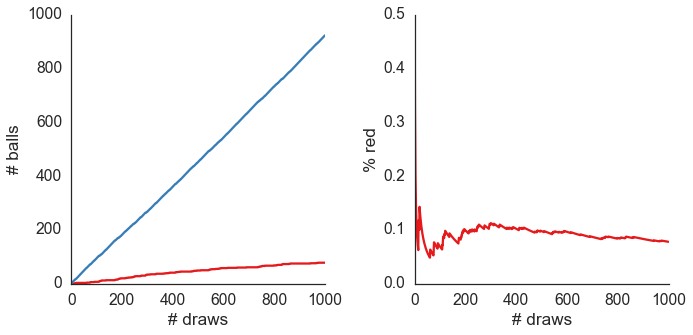

In [2]:
time = 1000
randoms = np.random.random(time)
red = np.ones(time)
blue = np.ones(time)

for t in range(1, time):
    red_freq = red[t-1] / (red[t-1] + blue[t-1])
    draw_red = randoms[t-1] < red_freq
    draw_blue = ~draw_red
    red[t] = red[t-1] + draw_red
    blue[t] = blue[t-1] + draw_blue

fig,ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 5))

ax[0].plot(red)
ax[0].plot(blue)
ax[0].set_xlabel('# draws')
ax[0].set_ylabel('# balls')

ax[1].plot(red / (red + blue))
ax[1].set_xlabel('# draws')
ax[1].set_ylabel('% red')

fig.tight_layout()
sns.despine()

## Branching process

One of the simplest stochastic process is the Branching process of the [Galton-Wason process](http://en.wikipedia.org/wiki/Galton%E2%80%93Watson_process). 

There was concern amongst the Victorians that aristocratic surnames were becoming extinct. 

Francis Galton originally posed the question regarding the probability of such an event in the _Educational Times_ of 1873, and the Reverend Henry William Watson replied with a solution (Watson & Galton, 1875). 

The process models family names as patrilineal (passed from father to son), while offspring are randomly either male or female, and names become extinct if the family name line dies out (holders of the family name die without male descendants). 

This is an accurate description of Y chromosome transmission in genetics, and the model is thus useful for understanding human Y-chromosome DNA haplogroups, and is also of use in understanding other processes (as described below); but its application to actual extinction of family names is fraught. In practice, family names change for many other reasons, and dying out of name line is only one factor.

To make matters a bit easier we will assume that if _N_ people have the same surname than it is protected from extinction. 
We further simplify the model by assuming that each male has $n$ offspring and each offspring has a probability $p$ to be male and reach repductive age.

In [3]:
sns.set_palette(sns.color_palette('muted'))
N = 1000
n = 3
p = 0.35 # probability for a reproductive son

We simulate a Branching process on the finite space ${0, 1, ..., N}$. 
Each state represents the population size - the number of males with the same surname. 

We assume that at each time step $t$ each male has $n$ offspring.
Each one of the offspring has a probability $p$ to become a reproductive male.
So $1-p$ includes female offspring and male offspring that do not reach reproductive age.

So the number of reproducrive boys per male has a Binomial distribution $B(n,p)$.

## Exercise

We can draw numbers from a Binomial distribution using `numpy.random.binomial`:

In [8]:
help(np.random.binomial)

Help on built-in function binomial:

binomial(...) method of mtrand.RandomState instance
    binomial(n, p, size=None)
    
    Draw samples from a binomial distribution.
    
    Samples are drawn from a binomial distribution with specified
    parameters, n trials and p probability of success where
    n an integer >= 0 and p is in the interval [0,1]. (n may be
    input as a float, but it is truncated to an integer in use)
    
    Parameters
    ----------
    n : float (but truncated to an integer)
            parameter, >= 0.
    p : float
            parameter, >= 0 and <=1.
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    
    Returns
    -------
    samples : ndarray or scalar
              where the values are all integers in  [0, n].
    
    See Also
    --------
    scipy.stats.distributions.binom 

- Use the `binomial` function in NumPy to draw random numbers.
- Plot the histogram of the numbers you've drawn
- Notice how the histogram changes everytime you run the code.
- Compare the histogram to the [binomial distribution](http://en.wikipedia.org/wiki/Binomial_distribution) probability mass function.

Histograms are plotted using Matplotlib's `hist` function or you could use `seaborn.distplot` to plot the histogram with a density plot on top (see [Visualizing distributions of data
 in Python](http://nbviewer.ipython.org/github/mwaskom/seaborn/blob/master/examples/plotting_distributions.ipynb)).

In [4]:
# You can change these values
size = 10000
n = 3
p = 0.34
# Your code goes here!

- How large should `size` be?
- Does it depend on the choice of `n` and `p`?
- Try to add the keyword argument `bins` to the `hist` function with a value of `100`.

## First simulation

Based on the assumptions above, the probability that a male has $k$ boys that will reach reproductive age is:

$$
{n \choose k} p^k (1-p)^{n - k}.
$$

To get the total number of male sin the next generation we need to draw lots of samples from this Binomial distribution and sum all the numbers. But the sum of many identical Binomial distributions is also a Binomial distribution. 
So if at generation $t$ we have $x_t$ males, then at generation $t+1$ the probability that the number of males is $k$ is:

$$
{n x_{t} \choose k} p^k (1-p)^{n x_{t} - k}
$$

This only depends on the number of males in generation $t$ - $x_t$ (the Markovian _lack of memory_ trait).
Note that if the number of males reaches _0_ or _N_, the process stops.

The `num_males` array will contain the **population size at each generation**.
We fill it with zeros just as placeholders and put the initial family size, 10, in the first element of the array.

We then loop over all the generations and at each generation we randomly draw the number of children in the next generation and update the `num_males` array.

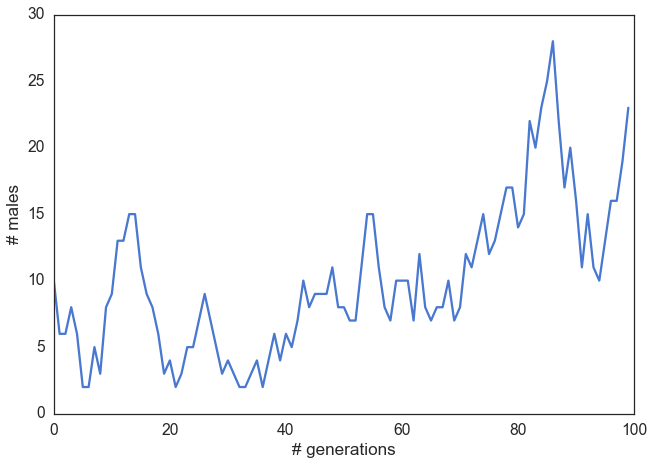

In [5]:
ngenerations = 100
num_males = np.zeros(ngenerations)
num_males[0] = 10

for t in range(ngenerations - 1):
    if 0 < num_males[t] < N:
        # Update the number of males in the next generation
        num_males[t+1] = np.random.binomial(n * num_males[t], p)
    # The process is absorbed in 0 and N
    else:
        num_males[t+1] = num_males[t]

plt.plot(num_males)
plt.xlabel('# generations')
plt.ylabel('# males');

We see that at every time step the number of males can stay stable, increase, or
decrease.

Run the simulation code again. Each time you run it you will get something else!

## Multiple simulations

Now, we will simulate many independent families. 

We could run the previous simulation with a loop, but it would be very slow (two nested for loops). 
Instead, we vectorize the simulation by considering all independent families at once. 
There is a single loop over time. 

At every time step, we update all families simultaneously with vectorized operations on vectors. 
The `num_males` array will now contains the number of males of all families at a particular time. 

We define a function that performs the simulation. 

At every time step, we find the families that have not reached the absorbing states 0 and $N$, and we update the number of males with array operations:

In [6]:
def simulate(num_males, ngenerations):
    for t in range(ngenerations):
        # Which families to update? Only ones that are not absorbed yet
        update = (0 < num_males) & (num_males < N)
        # In which families do male births occur?
        boys = np.random.binomial(num_males[update] * n, p)
        # We update the population size for the non-absorbed families.
        num_males[update] = boys

Now, let's look at the histograms of the number of males at different times.
These histograms represent the probability distribution of the Stochastic process over many replicates (many surnames),
estimated with independent families (this is often called the _Monte Carlo method_):

In [7]:
nfamilies = 100
n = 3
p = 0.35

bins = np.linspace(0, 1.2*N, 100)
ngenerations_list = [10, 100, 1000]

num_males = np.array([10] * nfamilies)

% families extinct: 0.21


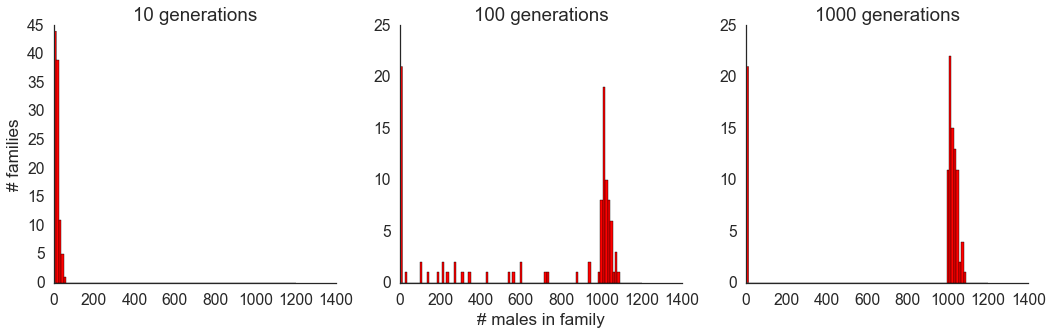

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=False)

for i, ngenerations in enumerate(ngenerations_list):
    simulate(num_males, ngenerations)
    ax[i].hist(num_males, bins=bins, color='red')
    ax[i].set_title("%d generations" % ngenerations)

ax[0].set_ylabel("# families")
ax[1].set_xlabel("# males in family")
fig.tight_layout()
sns.despine()
print("% families extinct:", (num_males==0).mean())

Initially, the number of males in all families started at 10.
After enough time passed it appears to converge to _0_ or _N_.
This is because the states _0_ and _N_ are absorbing; once reached, the chain cannot leave these states.

Furthermore, these states can be reached from any other state. 
From our crude analysis above we see that 1,000 generations are enough for most surnames to either go extinct or reach a size that protects them from extinction (under our simplistic assumptions).

Interestingly, the %  of extinct families is a good approximation to the probability of extinction (strating from 10 males).

## Exercise

The Poisson distribution is a commonly used for estimating number of offsprings.
The distribution is easy to use because it has a single parameter $\lambda$ with a clear interpretation: the average of the distribution.

We can draw a random number from a Poisson distribution using `numpy.random.poisson`. 

Below is a plot of a histogram (bars) and with an estimation of the distribution (line) of the Poisson distribution:

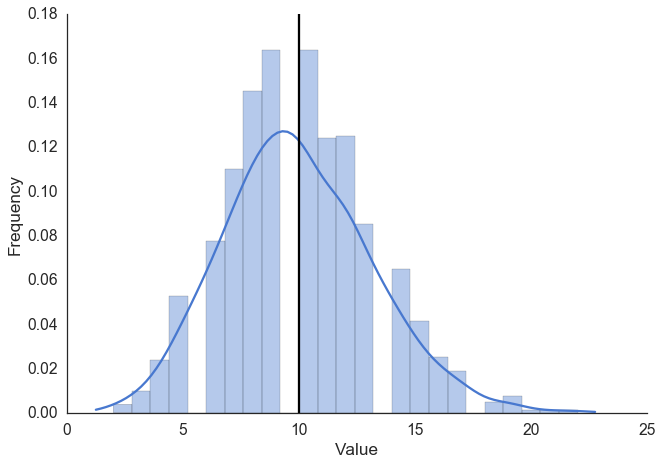

In [9]:
x = np.random.poisson(lam=10,size=1000)
sns.distplot(x)
plt.axvline(x=10, color='k')
plt.xlabel('Value')
plt.ylabel('Frequency')
sns.despine()

In the code below (copied from the simulation above), the number of sons is distributed Binomially with parameters $n$ and $p$.

Change the code so that the number of sons will be Poisson distributed 
with paramter $\lambda$ (you can call it `lam` in the code, as `lambda` is a reserved Python word).

What is the relationship between $\lambda$ and $n$ and $p$?

In [ ]:
ngenerations = 100
num_males = np.zeros(ngenerations)
num_males[0] = 10

for t in range(ngenerations - 1):
    if 0 < num_males[t] < N:
        # Update the number of males in the next generation
        num_males[t+1] = np.random.binomial(n * num_males[t], p)
    # The process is absorbed in 0 and N
    else:
        num_males[t+1] = num_males[t]

plt.plot(num_males)
plt.xlabel('# generations')
plt.ylabel('# males');

## Extinction probability

An interesting question regarding Branching processes is: what is the probability that given enough time, a lineage will extinct?

Let's rewrite our simulation function to start all sample populations to start with the same number of males and to continue until the number of males has reached an absorbing state - 0 or N.

The result of this function will be the final state of each trial population.

In [10]:
def simulate(init_num_males, n, p, nfamilies=100):
    num_males = init_num_males * np.ones(nfamilies, dtype=int)
    update = (0 < num_males) & (num_males < N)
    
    while update.any():
        # Which trials to update?
        update = (0 < num_males) & (num_males < N-1)
        # In which trials do births occur?
        boys = np.random.binomial(num_males[update] * n, p)
        # We update the population size for all trials.
        num_males[update] = boys
    return num_males

num_males = simulate(1, n, p)
print(num_males)

[   0 1075    0    0    0    0    0    0    0    0    0    0 1008    0    0
    0    0    0    0    0    0    0 1019    0 1007    0    0    0    0 1039
 1004    0 1036 1017    0    0    0 1020    0    0    0 1039    0    0    0
    0    0    0    0    0    0 1014    0 1043    0    0    0    0    0    0
    0    0    0    0 1009    0    0 1030    0    0    0    0    0    0 1005
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


We can estimate the extinction probability from the fraction of the simulations that ended with an extinction.
We can also estimate the standard error of the mean (SEM) as the square root of the sample standard deviation.

In [11]:
mean_prob = (num_males==0).mean()
sem_prob  = (num_males==0).std(ddof=1) / np.sqrt(len(num_males))
print("Extinction probability starting from a single male is %.2f ± %.4f" % (mean_prob, sem_prob))

Extinction probability starting from a single male is 0.85 ± 0.0359


Next we will estimate the extinction probability for different initial number of males and make an errorbar plot.

In [12]:
init_num_males_range = range(1,100,5)
prob = np.array([simulate(k, n, p) == 0 for k in init_num_males_range])

mean_prob = prob.mean(axis=1)
sem_prob = prob.std(axis=1) / np.sqrt(prob.shape[0])

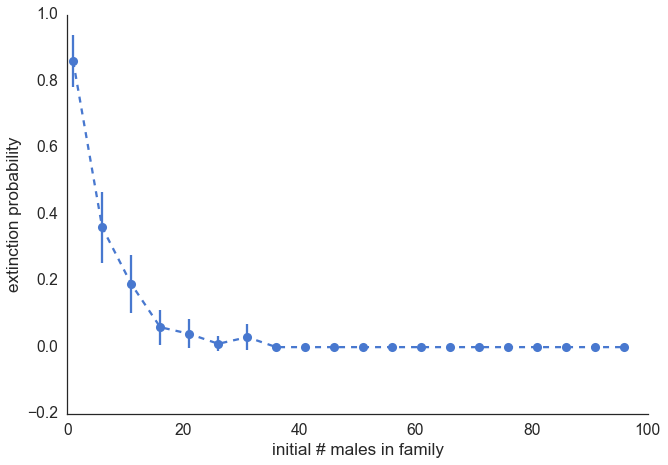

In [13]:
plt.errorbar(
    x=init_num_males_range, 
    y=mean_prob, 
    yerr=sem_prob, 
    marker='o', 
    ls='--'
)
plt.xlabel('initial # males in family')
plt.ylabel('extinction probability')
sns.despine()

## Exercise

It can be proven that:

> ### Theorem on extinction probability

> If the average number of sons is <= 1 the lineage will go to extinction with probability 1.
If the average number of sons is > 1 then the extinction probability is the stationary point of the moment generating function of the distribution of number of sons per male (see Athreya & Ney., 2011).

Let's check the theorem. 

Calculate the extinction probability of a single male for different values of $n \cdot p$ such that you include both values lower than 1 and higher than 1 and check that the extinction probability is 1 only when the average number of offspring is lower then 1.

In [58]:
init_num_males = 1
n  = 3

# Your code here

In [195]:
# More code here

## Stationary distribution

An interesting fact about some branching processes is that after enough time passsed, 
the probability to be at a specific state (_i.e._ for the number of males to be $k$) doesn't change from generation to generations.

This probability is called a _static distribution_. 

In the figure above you can see that the distribution for 10,000 and 100,000 generations is the same, 
so we can find the extinction probability by calculating the probability that there are 0 males after 10,000 generations:

To answer this question the model can be written in the following way. 
We denote by $v(t)=(v_0(t), v_1(t), ..., v_N(t))$ the probabilities that there are 0, 1, ..., $N$ males after $t$ generations.

We denote by $P_{i,j}$ the probability that there are $i$ males in generation $t+1$ given that there are $j$ males in generation $t$.
$P$ is called the _transition matrix_.

Let's consider a simpler model than before - in this model the population loses a single individual with probability $a$ and gains an individual with probability $b$. This is sometimes called a __birth-death process__ in which $a$ and $b$ are the death and birth rates, respectively.

This can be written by:
$$
v_i(t+1) = P_{i,0} v_0(t) + P_{i,1} v_1(t) + ... + P_{i,N} v_N(t) = \sum_{j=0}^{N}{P_{i,j}v_j(t)}
$$

of as a matrix equation:
$$
v(t+1) = P \cdot v(t)
$$

This matrix equation can be written and calculated using NumPy arrays. 

Let's use a simpler model in which the number of males is increased by 1 with probability $a$ and decreased by one with probability $b$:

$$
P_{i,j} = \left\{\begin{matrix}
a & i=j+1\\ 
b & i=j-1\\ 
1-a-b & i=j \\
0 & otherwise
\end{matrix}\right.
$$

So this matrix has a main diagonal with the value $1-a-b$, above it a diagonal with $a$ and below it a diagonal with $b$. Everything else is 0:

$$
P = \begin{pmatrix}
1-a-b & b & 0 & ... \\
a & 1-a-b & b & ... \\
0 & a & 1-a-b & ... \\
... & ... & ... & ...
\end{pmatrix}
$$

We can generate diagonal matrices using NumPy's `diag` function:

In [14]:
N = 1000
a = 0.3
b = 0.25

main_diag  = [1 - a - b] * (N+1)
lower_diag = [a] * N
upper_diag = [b]*  N
P = np.diag(main_diag) + np.diag(lower_diag, 1) + np.diag(upper_diag, -1)
P[0,0] = 1-b
P[N,N] = 1-a

print(P)
assert np.allclose(P.sum(axis=0), 1)

[[ 0.75  0.3   0.   ...,  0.    0.    0.  ]
 [ 0.25  0.45  0.3  ...,  0.    0.    0.  ]
 [ 0.    0.25  0.45 ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  0.45  0.3   0.  ]
 [ 0.    0.    0.   ...,  0.25  0.45  0.3 ]
 [ 0.    0.    0.   ...,  0.    0.25  0.7 ]]


Let's assume we start from a lineage of 100 males.
We'll iterate the matrix equation for 1000 times.
Matrix multiplication is done using NumPy's `dot` function.
Remember that order matters in matrix multiplication.

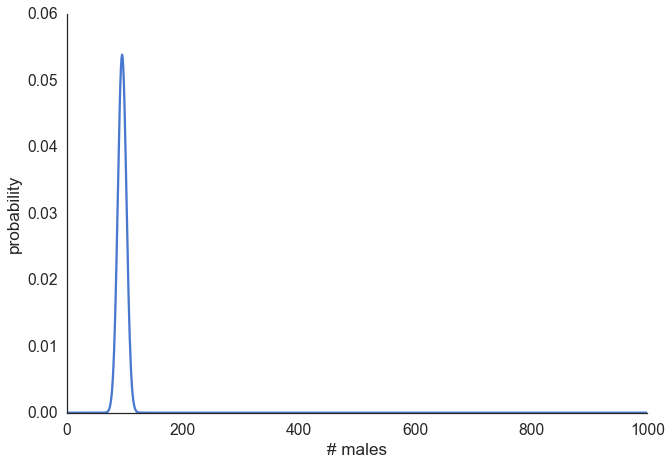

In [15]:
v = np.zeros(N+1)
v[100] = 1.
for _ in range(100):
    v = np.dot(P, v) # v = P @ v in Python 3.5
plt.plot(v)
plt.xlabel('# males')
plt.ylabel('probability')
sns.despine()

This is kind of slow. There is a short cut:
$$
v(t+2) = P \cdot v(t+1) = P \cdot P \cdot v(t) = P^2 \cdot p(t) \Rightarrow \\
v(t) = P^t \cdot v(0)
$$

Matrix power is done using `numpy.linalg.matrix_power`:

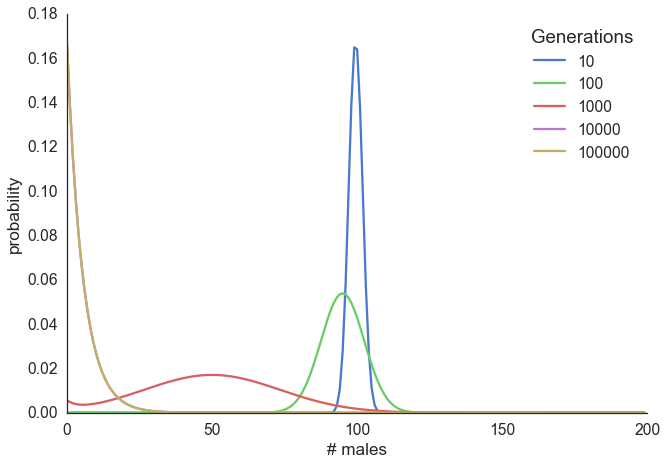

In [16]:
v = np.zeros(N+1)
v[100] = 1.

for generations in (10, 100, 1000, 10000, 100000):
    u = np.dot(np.linalg.matrix_power(P, generations), v)
    plt.plot(u[:200], label=generations)
    
plt.xlabel('# males')
plt.ylabel('probability')
plt.legend(title="Generations")
sns.despine()

## References

- Watson, HW & Galton, F. 1875. _On the Probability of the Extinction of Families_. _Journal of the Anthropological Institute of Great Britain_, 4:138–144. [PDF](http://galton.org/essays/1870-1879/galton-1874-jaigi-family-extinction.pdf)
- Athreya, K.B., Ney, P.E., 2011. _T. E. Harris and branching processes_. arXiv: [1103.2011](http://arxiv.org/abs/1103.2011).

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)